<a href="https://colab.research.google.com/github/helenpiepie/hl.github.io/blob/master/Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Analysis with GCP & AWS NLP APIs

## Ingest

In [0]:
from google.colab import files
uploaded  = files.upload()

Saving imdb_comment.csv to imdb_comment.csv


In [0]:
import pandas as pd
import numpy as np
import time
from matplotlib import pyplot as plt
import seaborn as sns
imdb = pd.read_csv("imdb_comment.csv")

## EDA

In [0]:
imdb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 3 columns):
Text              100 non-null object
Sentiment         100 non-null int64
AnalysisResult    100 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 2.4+ KB


In [0]:
imdb.head()

,Text,Sentiment
0,"first think another Disney movie, might good, ...",1
1,"Put aside Dr. House repeat missed, Desperate H...",0
2,"big fan Stephen King's work, film made even gr...",1
3,watched horrid thing TV. Needless say one movi...,0
4,truly enjoyed film. acting terrific plot. Jeff...,1


Text(0.5, 1.0, 'Density Plot of Original Sentiment Score for Movie Reviews ')

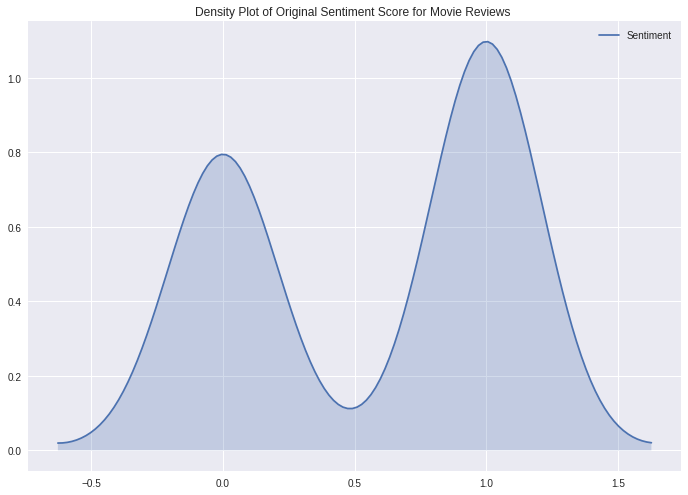

In [0]:
fig, ax = plt.subplots()
sns.kdeplot(imdb['Sentiment'], shade=True, ax=ax)
fig.set_size_inches(11.7, 8.27)
ax.set_title("Density Plot of Original Sentiment Score for Movie Reviews ")

## Google Cloud Platform - Natural Language API

### Call API

First, getting a Google API Credential.
Visit API console, choose "Credentials" on the left-hand menu. Choose "Create Credentials" and generate an API key for my application. 

Then, I will enter it in this first executable cell:

In [0]:
import getpass

APIKEY = getpass.getpass()

··········


From the API console, choose "Dashboard" on the left-hand menu and "Enable API".

Enable the following APIs for my project "Natural Language API" and enable it.

Finally, calling the APIs from Python (install the Python package)

In [0]:
!pip install --upgrade pip

!pip install --upgrade google-api-python-client

Requirement already up-to-date: pip in /usr/local/lib/python3.6/dist-packages (19.0.3)
Requirement already up-to-date: google-api-python-client in /usr/local/lib/python3.6/dist-packages (1.7.8)


In [0]:
# running API
from googleapiclient.discovery import build
lservice = build('language', 'v1beta1', developerKey=APIKEY)

### Sampling and running sentiment analysis to see the result

In [0]:
sample = imdb.head(5)
sample_text = sample["Text"]
start = time.clock()
for quote in sample_text:
  response = lservice.documents().analyzeSentiment(
    body={
      'document': {
         'type': 'PLAIN_TEXT',
         'content': quote
      }
    }).execute()
  polarity = response['documentSentiment']['polarity']
  magnitude = response['documentSentiment']['magnitude']
  print('POLARITY=%s MAGNITUDE=%s for %s' % (polarity, magnitude, quote))
end = time.clock()
print("Run Time：%s"%(end-start))

POLARITY=0.5 MAGNITUDE=5 for first think another Disney movie, might good, it's kids movie. watch it, can't help enjoy it. ages love movie. first saw movie 10 8 years later still love it! Danny Glover superb could play part better. Christopher Lloyd hilarious perfect part. Tony Danza believable Mel Clark. can't help, enjoy movie! give 10/10!
POLARITY=-0.1 MAGNITUDE=3.9 for Put aside Dr. House repeat missed, Desperate Housewives (new) watch one. don't know exactly plagued movie. never thought I'd say this, want 15 minutes fame back.<br /><br />Script, Direction, can't say. recognized stable actors (the usual suspects), thought Herbert Marshall class addition sat good cheesy flick. Boy, wrong. Dullsville.<br /><br />My favorite parts: "office girl" makes 029 keypunch puts cards 087 sorter. LOL @ "the computer". I'd like someone identify next device - 477 ? It's even dinosaur's time.<br /><br />And dinosaurs don't much time waste.
POLARITY=0.4 MAGNITUDE=11.1 for big fan Stephen King's wor

### Running sentiment analysis on the full dataset

In [0]:
full_text = imdb["Text"]
full_result = []
start = time.clock()
for quote in full_text:
  response = lservice.documents().analyzeSentiment(
    body={
      'document': {
         'type': 'PLAIN_TEXT',
         'content': quote
      }
    }).execute()
  polarity = response['documentSentiment']['polarity']
  full_result.append(polarity)
end = time.clock()
print("Run Time：%s"%(end-start))

Run Time：0.2599049999999963


In [0]:
df = pd.DataFrame(full_result, columns = ["Polarity"])
gcp_imdb = imdb.copy()
gcp_imdb["AnalysisResult"] = df["Polarity"]
gcp_imdb.head()

,Text,Sentiment,AnalysisResult
0,"first think another Disney movie, might good, ...",1,0.5
1,"Put aside Dr. House repeat missed, Desperate H...",0,-0.1
2,"big fan Stephen King's work, film made even gr...",1,0.4
3,watched horrid thing TV. Needless say one movi...,0,-0.5
4,truly enjoyed film. acting terrific plot. Jeff...,1,0.7


Text(0.5, 1.0, 'Density Plot of Sentiment Analysis for Movie Reviews via GCP NLP ')

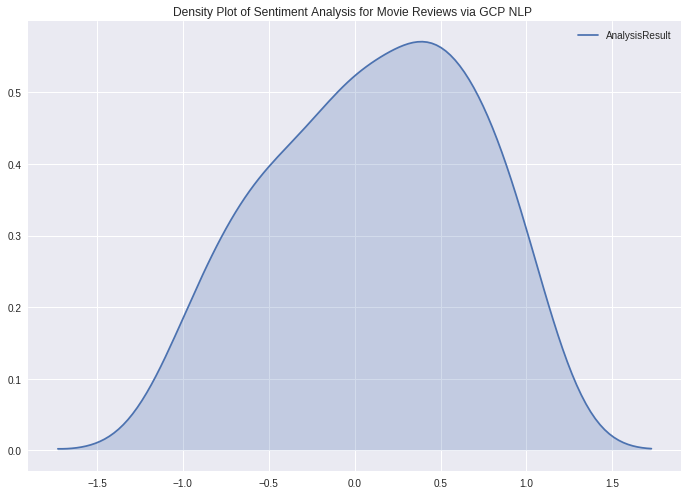

In [0]:
fig, ax = plt.subplots()
sns.kdeplot(gcp_imdb['AnalysisResult'], shade=True, ax=ax)
fig.set_size_inches(11.7, 8.27)
ax.set_title("Density Plot of Sentiment Analysis for Movie Reviews via GCP NLP ")

## Amazon Web Services - Comprehend API

### Call API

**Mount GoogleDrive**

In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [0]:
import os;os.listdir("/content/gdrive/My Drive/aws")

['awscredentials.txt']

**Install Boto**

In [0]:
!pip -q install boto3

**Create API Config**

In [0]:
!mkdir -p ~/.aws &&\
  cp /content/gdrive/My\ Drive/aws/awscredentials.txt ~/.aws/credentials

### Test Comprehend API Call

In [0]:
import boto3
comprehend = boto3.client(service_name='comprehend', region_name="us-west-2")
text = "There is smoke in San Francisco"
response = comprehend.detect_sentiment(Text=text, LanguageCode='en')
response

{'ResponseMetadata': {'HTTPHeaders': {'connection': 'keep-alive',
   'content-length': '160',
   'content-type': 'application/x-amz-json-1.1',
   'date': 'Mon, 04 Mar 2019 01:33:07 GMT',
   'x-amzn-requestid': '769460f2-3e1d-11e9-98a8-71f88e0c7527'},
  'HTTPStatusCode': 200,
  'RequestId': '769460f2-3e1d-11e9-98a8-71f88e0c7527',
  'RetryAttempts': 0},
 'Sentiment': 'NEUTRAL',
 'SentimentScore': {'Mixed': 0.008628507144749165,
  'Negative': 0.1037612184882164,
  'Neutral': 0.8582549691200256,
  'Positive': 0.0293553676456213}}

**Create a Function to Select Sentiment Result and Score**

In [0]:
from functools import reduce  # forward compatibility for Python 3
import operator

def getFromDict(dataDict, mapList):
    return reduce(operator.getitem, mapList, dataDict)

In [0]:
getFromDict(response, ["Sentiment"])

'NEGATIVE'

### Running Sentiment Analysis on Full Dataset

In [0]:
full_text = imdb["Text"]
aws_result = []
start = time.clock()
for quote in full_text:
  response = comprehend.detect_sentiment(Text=quote, LanguageCode='en')
  polarity = getFromDict(response, ["Sentiment"])
  neg = getFromDict(response, ["SentimentScore", "Negative"])
  pos = getFromDict(response, ["SentimentScore", "Positive"])
  score = -1 *neg + 1 *pos
  aws_result.append((polarity, score))

end = time.clock()
print("Run Time：%s"%(end-start))

Run Time：0.3423829999999981


In [0]:
aws_df = pd.DataFrame(aws_result, columns = ["Polarity","Score"])
aws_imdb = imdb.copy()
aws_imdb["AnalysisResult"] = aws_df["Polarity"]
aws_imdb["AnalysisScore"] = aws_df["Score"]
aws_imdb.head()

,Text,Sentiment,AnalysisResult,AnalysisScore
0,"first think another Disney movie, might good, ...",1,POSITIVE,0.995162
1,"Put aside Dr. House repeat missed, Desperate H...",0,NEUTRAL,0.086924
2,"big fan Stephen King's work, film made even gr...",1,POSITIVE,0.853342
3,watched horrid thing TV. Needless say one movi...,0,NEGATIVE,-0.606309
4,truly enjoyed film. acting terrific plot. Jeff...,1,POSITIVE,0.948225


Text(0.5, 1.0, 'Density Plot of Sentiment Analysis for Movie Reviews via AWS Comprehend ')

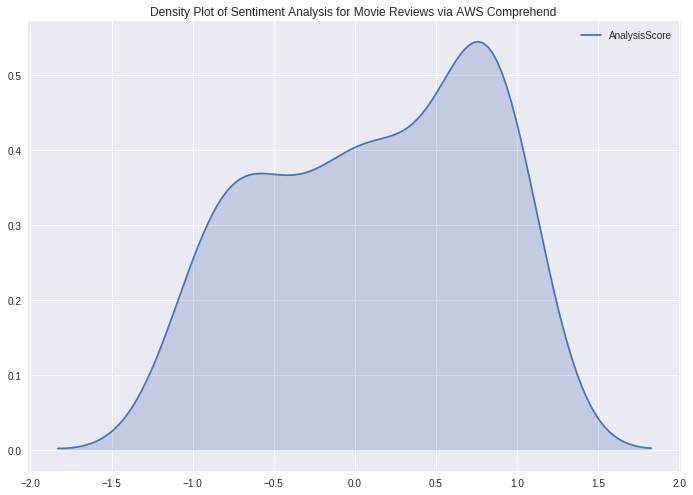

In [0]:
fig, ax = plt.subplots()
sns.kdeplot(aws_imdb['AnalysisScore'], shade=True, ax=ax)
fig.set_size_inches(11.7, 8.27)
ax.set_title("Density Plot of Sentiment Analysis for Movie Reviews via AWS Comprehend ")

## Conslusion



*   Both Google Natural Language and Amazon Comprehend are powerful in processing natural language and easy to use. The two services use machine learning to help uncover the insights and relationships in unstructured data. They can quickly identify the language of the text and understand how positive or negative the text is. 
*   Roughly, the analysis results of the two services are similar. Since the presentations of the results of Amazon are more detailed and mature than Google in sentiment analysis, I would recommend using Amazon Comprehend for more details of the text. 

